In [1]:
!python -V

Python 3.11.7


In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import pickle

In [3]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.50,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.50,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.50,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.50,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.00,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN


In [4]:
!pip install pyarrow

In [5]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [6]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [9]:
df = df[df.trip_type == 2 ]

/tmp/ipykernel_1638/4152507757.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration) #to see the distribution
/home/ubuntu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='duration', ylabel='Density'>

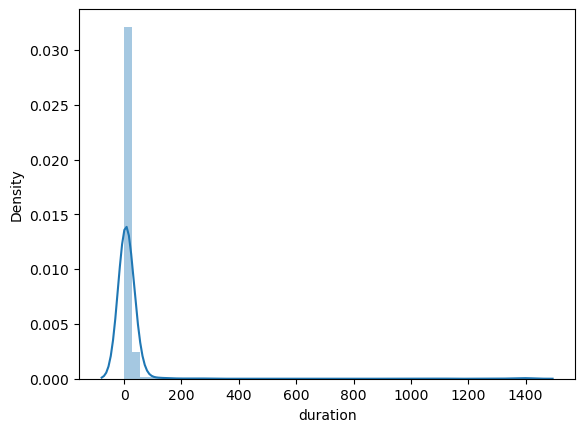

In [10]:
sns.distplot(df.duration) #to see the distribution

In [12]:
#long tail, so:
df.duration.describe()

count    1238.000000
mean       18.305493
std       108.364382
min         0.000000
25%         0.100000
50%         1.666667
75%        14.216667
max      1416.100000
Name: duration, dtype: float64

In [13]:
df.duration.describe(percentiles = [0.95, 0.98, 0.9])

count    1238.000000
mean       18.305493
std       108.364382
min         0.000000
50%         1.666667
90%        26.901667
95%        35.604167
98%        59.339333
max      1416.100000
Name: duration, dtype: float64

In [15]:
((df.duration > 1 ) & (df.duration < 60)).mean() #tra 1 minuto e 1 ora

0.5169628432956381

In [17]:
((df.duration > 0 ) & (df.duration < 1)).mean() #entra un minuto


0.4596122778675283

In [20]:
df = df[(df.duration >= 1 ) & (df.duration <= 60)]
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
30,2,2021-01-01 00:35:29,2021-01-01 00:55:15,N,5.0,74,247,1.0,3.64,13.0,...,0.0,0.0,0.0,None,0.3,13.3,2.0,2.0,0.0,19.766667
53,2,2021-01-01 01:54:51,2021-01-01 02:15:35,N,5.0,74,94,1.0,5.82,18.0,...,0.0,0.0,0.0,None,0.3,18.3,2.0,2.0,0.0,20.733333
69,2,2021-01-01 02:42:49,2021-01-01 02:50:59,N,5.0,136,241,1.0,0.57,9.0,...,0.0,0.0,0.0,None,0.3,9.3,2.0,2.0,0.0,8.166667
88,2,2021-01-01 04:52:02,2021-01-01 05:05:01,N,5.0,247,75,1.0,3.43,15.0,...,0.0,0.0,0.0,None,0.3,15.3,2.0,2.0,0.0,12.983333
96,2,2021-01-01 05:52:43,2021-01-01 05:58:02,N,5.0,7,7,1.0,0.65,50.0,...,0.0,7.0,0.0,None,0.3,57.3,1.0,2.0,0.0,5.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40324,2,2021-01-31 18:42:52,2021-01-31 19:08:44,N,5.0,69,213,2.0,5.40,16.0,...,0.0,0.0,0.0,None,0.3,16.3,2.0,2.0,0.0,25.866667
40352,1,2021-01-31 19:32:22,2021-01-31 19:50:16,N,5.0,82,129,2.0,2.40,0.0,...,0.0,0.0,0.0,None,0.0,0.0,2.0,2.0,0.0,17.900000
40363,2,2021-01-31 19:26:20,2021-01-31 19:35:47,N,5.0,167,248,2.0,1.31,10.0,...,0.0,0.0,0.0,None,0.3,10.3,2.0,2.0,0.0,9.450000
40364,2,2021-01-31 19:44:54,2021-01-31 20:19:56,N,5.0,147,147,2.0,6.97,30.0,...,0.0,0.0,0.0,None,0.3,30.3,2.0,2.0,0.0,35.033333


In [31]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [32]:
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [33]:
df[categorical] = df[categorical].astype(str)

In [34]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [37]:
df[categorical + numerical].iloc[:10].to_dict(orient='records')

[{'PULocationID': '74', 'DOLocationID': '247', 'trip_distance': 3.64},
 {'PULocationID': '74', 'DOLocationID': '94', 'trip_distance': 5.82},
 {'PULocationID': '136', 'DOLocationID': '241', 'trip_distance': 0.57},
 {'PULocationID': '247', 'DOLocationID': '75', 'trip_distance': 3.43},
 {'PULocationID': '7', 'DOLocationID': '7', 'trip_distance': 0.65},
 {'PULocationID': '152', 'DOLocationID': '152', 'trip_distance': 0.1},
 {'PULocationID': '159', 'DOLocationID': '159', 'trip_distance': 0.27},
 {'PULocationID': '116', 'DOLocationID': '247', 'trip_distance': 1.21},
 {'PULocationID': '195', 'DOLocationID': '106', 'trip_distance': 0.49},
 {'PULocationID': '74', 'DOLocationID': '236', 'trip_distance': 2.12}]

In [38]:
train_dict = df[categorical + numerical].to_dict(orient='records')

In [39]:
dv = DictVectorizer()

In [40]:
X_train = dv.fit_transform(train_dict)

In [42]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=112',
 'DOLocationID=116',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=121',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=138',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=143',
 'DOLocationID=145',
 'DOLocationID=146',
 'DOLocationID=147',
 'DOLocationID=148',
 'DOLocationID=151',
 'DOLocationID=152',
 'DOLocationID=156',
 'DOLocationID=159',
 'DOLocationID=16',
 'DOLocationID=161',
 'DOLocationID=162',
 'DOLocationID=163',
 'DOLocationID=165',
 'DOLocationID=166',
 'DOLocationID=167',
 'DOLocationID=168',
 'DOLocationID=169',
 'DOLocationID=17',
 'DOLocationID=170',
 'DOLocationID=173',
 'DOLocationID=174',
 'DOLocationID=177',
 'DOLocationID=179',
 'DOLocationID=18',
 'DOLocationID=182'

In [43]:
target = 'duration'
y_train = df[target].values

In [44]:
y_train

array([19.76666667, 20.73333333,  8.16666667, 12.98333333,  5.31666667,
        1.26666667,  1.6       ,  5.03333333,  1.86666667,  6.38333333,
       34.71666667,  1.35      , 27.23333333,  9.11666667, 26.23333333,
       28.75      , 22.01666667, 21.85      , 20.96666667, 21.61666667,
        9.26666667, 22.63333333, 25.41666667,  1.2       , 16.7       ,
       49.2       ,  7.35      , 14.16666667, 13.58333333, 24.06666667,
       24.2       , 27.21666667, 19.61666667, 12.71666667, 18.83333333,
        6.26666667,  2.53333333, 13.26666667,  7.63333333, 54.71666667,
        3.75      ,  4.15      ,  3.65      , 10.26666667,  5.6       ,
        2.93333333, 33.95      ,  6.53333333, 10.08333333, 21.96666667,
       30.96666667,  5.78333333, 11.05      ,  7.35      , 18.15      ,
       10.25      ,  1.95      ,  1.95      , 38.2       , 12.3       ,
       14.03333333, 16.91666667,  3.83333333, 14.31666667,  7.01666667,
       19.56666667,  6.41666667, 38.48333333, 34.98333333, 10.38

In [48]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [49]:
lr.predict(X_train)

array([15.3625517 , 27.09648655,  8.16716883, 11.8967799 ,  4.27480963,
        2.37064367,  9.75944836, 12.27134583,  1.8635056 ,  8.97986717,
       35.87783248,  8.89139983, 28.29309456,  6.66795412, 27.72203251,
       21.34311544, 16.78558273, 12.61036462, 20.32741176, 51.91504393,
       13.28652179, 22.62696949, 25.41872746,  4.5276749 , 14.50569084,
       26.93140249,  6.74301756, 12.62509282, 11.42855618, 15.49712876,
       22.99177265, 24.11663252, 19.61521274, 18.45104835, 20.84228734,
        5.43818226,  5.48318852, 14.14326547,  6.49980406, 36.13405325,
        6.40879738, 10.33664879,  6.36967387, 14.4830401 ,  5.77867594,
        5.16491003, 33.9540067 ,  5.60166235,  7.39824   , 30.1037708 ,
       13.77814968, 18.03469369,  8.42868294,  8.83939398, 19.74970223,
       21.22504851,  1.95036627,  1.95036627, 34.62130649, 12.48590715,
       15.01825691, 19.92239545,  4.76332209, 12.1847004 ,  2.40006104,
       17.72824136,  9.5033864 , 19.10188576, 34.98559223, 10.38

In [51]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_1638/4289645433.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/home/ubuntu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_1638/4289645433.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level functi

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

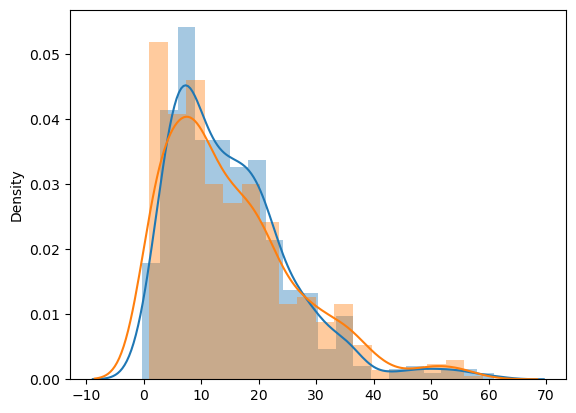

In [52]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend

In [54]:
mean_squared_error(y_train, y_pred, squared=False)

4.803126264559265

In [55]:
categorical = []

In [56]:
df[categorical] = df[categorical].astype(str)
train_dict = df[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

/tmp/ipykernel_1638/4289645433.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/home/ubuntu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_1638/4289645433.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level functi

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

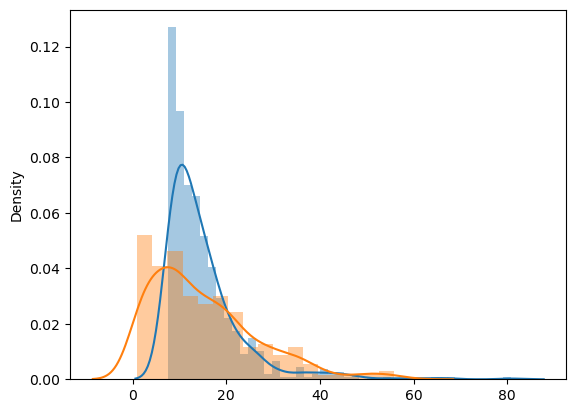

In [57]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend

In [58]:
mean_squared_error(y_train, y_pred, squared=False)

7.694380317719222

In [62]:
#creating a function
def read_df(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >= 1 ) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)

    return df

In [64]:
df_train = read_df('./data/green_tripdata_2021-01.parquet')
df_val = read_df('./data/green_tripdata_2021-02.parquet')

In [65]:
len(df_train), len(df_val)

(73908, 61921)

In [69]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [70]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

10.499110713790529

In [71]:
lr = Lasso()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

12.212583224318818

In [74]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

10.481255832596219

In [79]:
lr = Ridge(alpha=0.01)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

10.476410002487743

In [80]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

df_val

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-02-01 00:34:03,2021-02-01 00:51:58,N,1.0,130,205,5.0,3.66,14.00,...,10.00,0.0,None,0.3,25.30,1.0,1.0,0.00,17.916667,130_205
1,2,2021-02-01 00:04:00,2021-02-01 00:10:30,N,1.0,152,244,1.0,1.10,6.50,...,0.00,0.0,None,0.3,7.80,2.0,1.0,0.00,6.500000,152_244
2,2,2021-02-01 00:18:51,2021-02-01 00:34:06,N,1.0,152,48,1.0,4.93,16.50,...,0.00,0.0,None,0.3,20.55,2.0,1.0,2.75,15.250000,152_48
3,2,2021-02-01 00:53:27,2021-02-01 01:11:41,N,1.0,152,241,1.0,6.70,21.00,...,0.00,0.0,None,0.3,22.30,2.0,1.0,0.00,18.233333,152_241
4,2,2021-02-01 00:57:46,2021-02-01 01:06:44,N,1.0,75,42,1.0,1.89,8.50,...,2.45,0.0,None,0.3,12.25,1.0,1.0,0.00,8.966667,75_42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64567,2,2021-02-28 22:19:00,2021-02-28 22:29:00,None,NaN,129,7,NaN,2.63,10.04,...,0.00,0.0,None,0.3,10.34,NaN,NaN,NaN,10.000000,129_7
64568,2,2021-02-28 23:18:00,2021-02-28 23:27:00,None,NaN,116,166,NaN,1.87,8.33,...,1.89,0.0,None,0.3,10.52,NaN,NaN,NaN,9.000000,116_166
64569,2,2021-02-28 23:44:00,2021-02-28 23:58:00,None,NaN,74,151,NaN,2.40,12.61,...,0.00,0.0,None,0.3,12.91,NaN,NaN,NaN,14.000000,74_151
64570,2,2021-02-28 23:07:00,2021-02-28 23:14:00,None,NaN,42,42,NaN,1.11,11.95,...,0.00,0.0,None,0.3,15.00,NaN,NaN,NaN,7.000000,42_42


In [81]:
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [85]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715207014002

In [87]:
with open('/home/ubuntu/models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)
